# Imports Libraries and Tools

In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

# from keras library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle


## Load Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_path = "/content/drive/MyDrive/archive.zip"  # Path to your zip file
extract_dir = "/content/dataset"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")


Extraction complete.


In [4]:
import os

for root, dirs, files in os.walk("/content/dataset"):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", files)
    break  # Remove this to explore all levels


Root: /content/dataset
Dirs: ['Training', 'Testing']
Files: []


In [5]:
import os

train_dir = '/content/dataset/Training/'
test_dir = '/content/dataset/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        print("Found label:", label)
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            train_paths.append(img_path)
            train_labels.append(label)

print(f"Total training images: {len(train_paths)}")


Found label: meningioma
Found label: pituitary
Found label: glioma
Found label: notumor
Total training images: 5712


In [6]:
import os
from sklearn.utils import shuffle

train_dir = '/content/dataset/Training/'
test_dir = '/content/dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            train_paths.append(os.path.join(label_path, image))
            train_labels.append(label)

# Shuffle both paths and labels together
train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)

# Show the first few paths
train_paths[:5]


['/content/dataset/Training/pituitary/Tr-pi_0232.jpg',
 '/content/dataset/Training/glioma/Tr-gl_0670.jpg',
 '/content/dataset/Training/meningioma/Tr-me_1254.jpg',
 '/content/dataset/Training/notumor/Tr-no_0064.jpg',
 '/content/dataset/Training/notumor/Tr-no_1529.jpg']

## Test data

In [7]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            test_paths.append(os.path.join(label_path, image))
            test_labels.append(label)

# Shuffle both paths and labels together
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

# Show the first few paths
test_paths[:5]

['/content/dataset/Testing/notumor/Te-no_0029.jpg',
 '/content/dataset/Testing/notumor/Te-no_0101.jpg',
 '/content/dataset/Testing/meningioma/Te-me_0065.jpg',
 '/content/dataset/Testing/pituitary/Te-pi_0185.jpg',
 '/content/dataset/Testing/pituitary/Te-pi_0101.jpg']

## Data Visualization

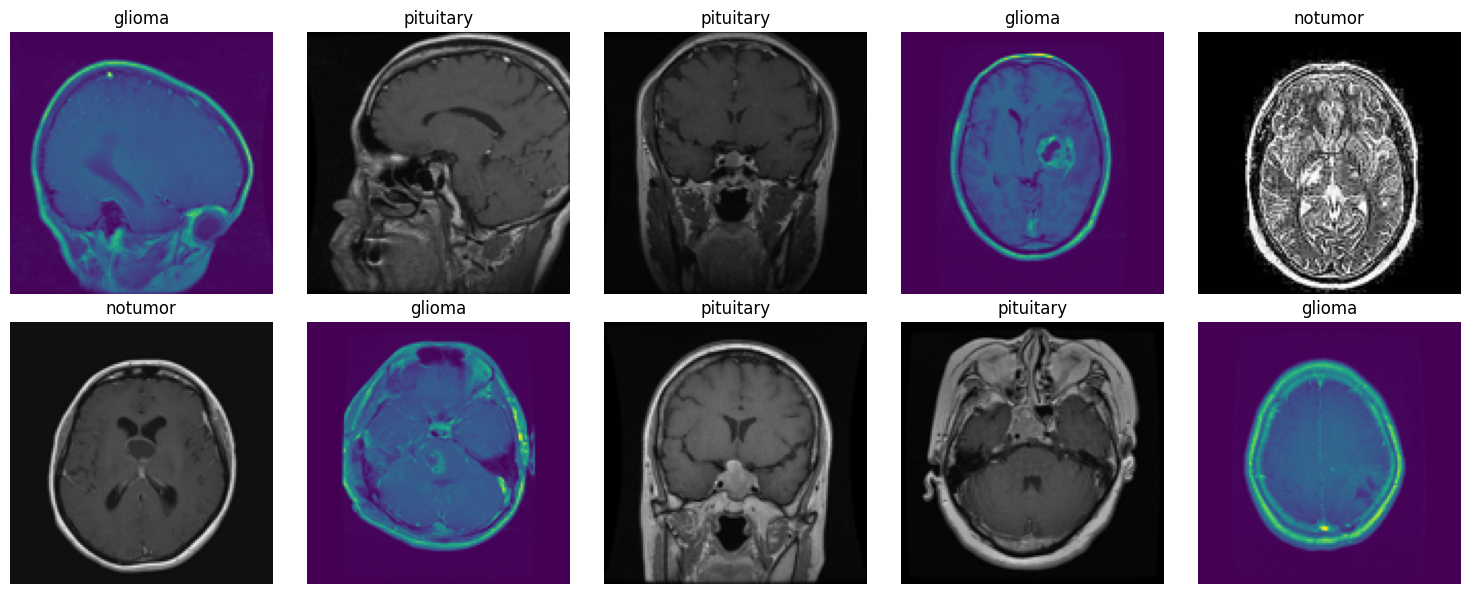

In [8]:
import random
import matplotlib.pyplot as plt

# Choose 10 random indices from the dataset
random_indices = random.sample(range(len(train_paths)), 10)

# Create the image display grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # flatten 2D array to 1D for easy indexing

# Loop through random indices and display images
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128, 128))  # Use tuple for size

    axes[i].imshow(img)
    axes[i].set_title(train_labels[idx])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## Image Preprocessing

In [9]:

IMAGE_SIZE = 128  # Ensure this matches the rest of your pipeline

# Image Augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))  # If image is already a PIL image, this may not be necessary
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    # image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8, 1.2))  # Optional
    image = np.array(image) / 255.0
    return image

# Load the image and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = np.array(img)  # Convert to array before augmentation
        img = augment_image(img)
        images.append(img)
    return np.array(images)


# Encode Labels (Convert label names into integers)
def encode_labels(labels):
    unique_labels = sorted(os.listdir(train_dir))
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)


# Data Generator for the batches
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            batch_images = open_images(batch_paths)
            batch_labels = encode_labels(batch_labels)

            yield batch_images, batch_labels


## Model Architecture

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import os

IMAGE_SIZE = 128

# Load VGG16 base model
base_model = VGG16(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Training parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 20

# Train the model
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
    steps_per_epoch=steps,
    epochs=epochs
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - loss: 0.6700 - sparse_categorical_accuracy: 0.7401
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - loss: 0.2552 - sparse_categorical_accuracy: 0.9040
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.1577 - sparse_categorical_accuracy: 0.9375
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9544
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9659
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - loss: 0.0663 - sparse_categorical_accuracy: 0.9787
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9753
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.0598 - sparse_categorical_accuracy: 0.9770
Epoch 9/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.0433 - sparse_categorical_acc

## Train and Validation plot

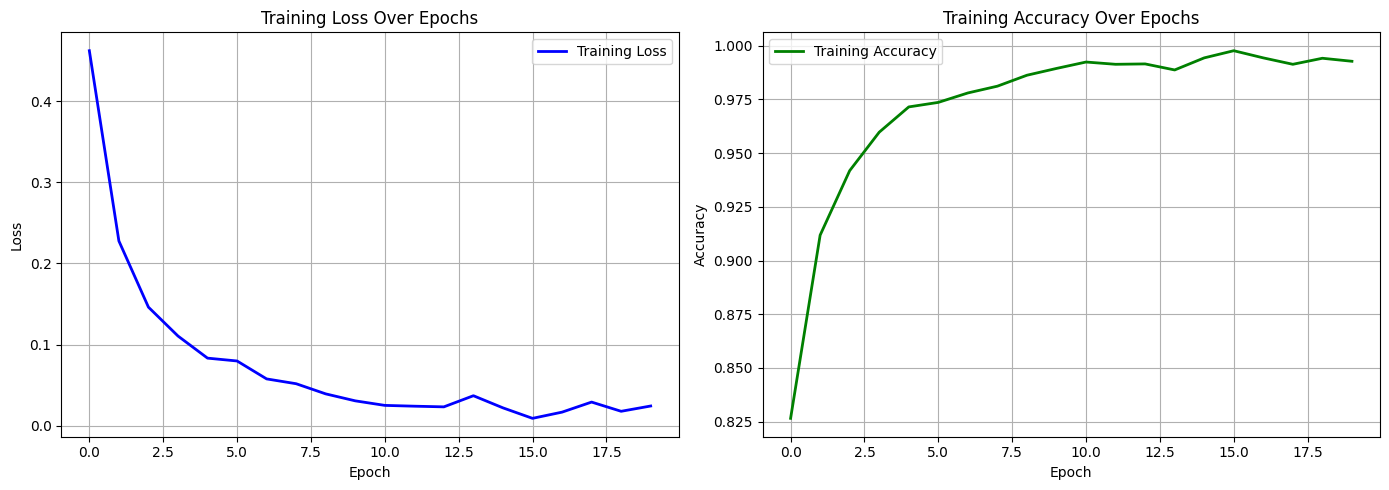

In [11]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training Loss
axs[0].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
axs[0].set_title('Training Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)
axs[0].legend()

# Plot Training Accuracy
axs[1].plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy', color='green', linewidth=2)
axs[1].set_title('Training Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


## Model Classification Report

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

# Load test images
test_images = open_images(test_paths)

# Correct: Encode test labels (use correct function and pass test_labels, not test_paths)
test_labels_encoded = encode_labels(test_labels)  # You had a typo: 'econded_label' and used test_paths

# Predict on test images
test_predictions = model.predict(test_images)

# Convert predictions to class indices
predicted_classes = np.argmax(test_predictions, axis=1)

# Classification report
print(classification_report(test_labels_encoded, predicted_classes))



41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       300
           1       0.96      0.98      0.97       306
           2       0.99      1.00      1.00       405
           3       1.00      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



## Confiusion Matrix

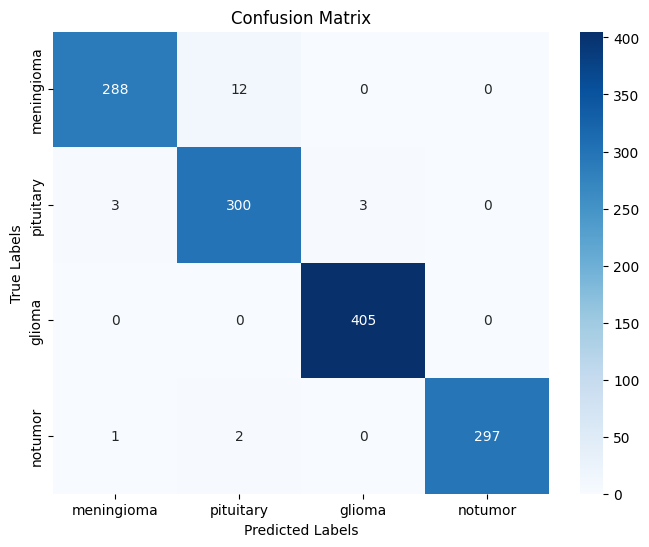

In [13]:
# Confusion matrix
cm = confusion_matrix(test_labels_encoded, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=os.listdir(train_dir),
    yticklabels=os.listdir(train_dir)
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


## ROC Curve

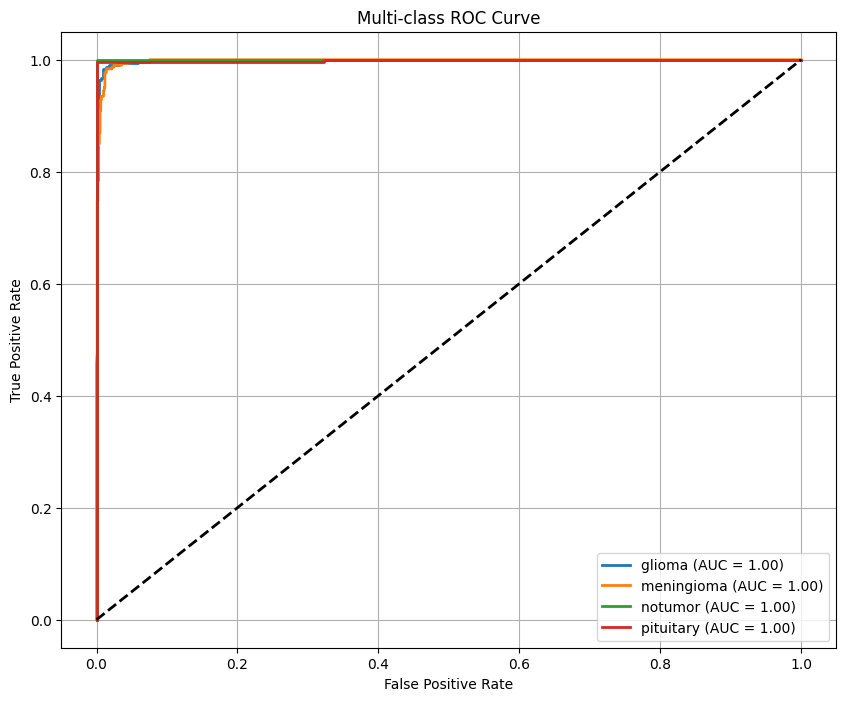

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os

# Number of classes
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Binarize the true labels (assumed test_labels_encoded are integer encoded labels)
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(n_classes))

# pred_probs should be your model prediction probabilities on test images
# Make sure pred_probs shape is (num_samples, n_classes)
pred_probs = test_predictions  # rename for clarity

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Save & Load the model

In [15]:
# Save the model
model.save('model.h5')


## MRI Tumor Detection System

In [16]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, class_names=class_labels):
    try:
        # Load and preprocess image
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0  # normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

        # Predict
        preds = model.predict(img_array)
        pred_class_idx = np.argmax(preds, axis=1)[0]
        pred_class_name = class_names[pred_class_idx]
        pred_confidence = preds[0][pred_class_idx]

        # Determine result text based on prediction
        if pred_class_name == 'notumor':
            result_text = "No Tumor Detected"
        else:
            result_text = f"Tumor: {pred_class_name}"

        # Display image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{result_text} (Confidence: {pred_confidence*100:.2f})")
        plt.show()

        return pred_class_name, pred_confidence

    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None, None


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


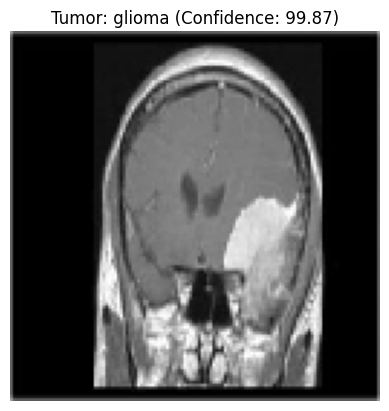

('glioma', np.float32(0.9986878))

In [17]:
# Image path
image_path='/content/dataset/Testing/meningioma/Te-meTr_0000.jpg'
detect_and_display(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


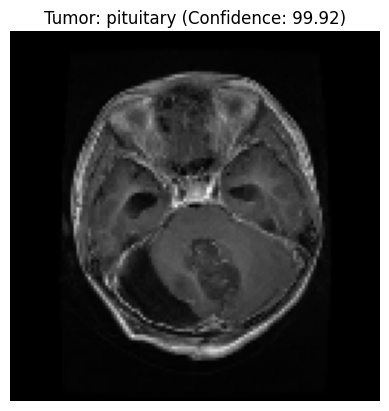

('pituitary', np.float32(0.999218))

In [18]:
image_path='/content/dataset/Testing/glioma/Te-glTr_0000.jpg'
detect_and_display(image_path, model)